# Predictive Analytics: Simple Demand Forecast
**Learning goals**
- Create a daily demand series with seasonality and promotions.
- Engineer simple features (DoW, lag) and fit a linear model.
- Compare actual vs predicted and run a quick what-if.

> No external data needed.


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
rng = np.random.default_rng(123)

# Simulate demand
days = pd.date_range("2025-01-01", periods=180, freq="D")
dow = days.dayofweek.values  # 0=Mon
base = 200 + 20*np.sin(2*np.pi*np.arange(len(days))/7)  # weekly seasonality
promo = rng.choice([0,1], size=len(days), p=[0.8,0.2])
noise = rng.normal(0,10,size=len(days))
demand = (base + 50*promo + noise).round(0).astype(int)
df = pd.DataFrame({"Date":days,"Demand":demand,"Promo":promo})
df["DoW"] = dow

# lag feature
df["Lag1"] = df["Demand"].shift(1)
df = df.dropna().reset_index(drop=True)

# Train/test split
train = df.iloc[:-30].copy()
test  = df.iloc[-30:].copy()
Xtr = train[["Promo","DoW","Lag1"]]; ytr = train["Demand"]
Xte = test[["Promo","DoW","Lag1"]];  yte = test["Demand"]

# Fit model
model = LinearRegression().fit(Xtr, ytr)
test["Pred"] = model.predict(Xte)
mae = mean_absolute_error(yte, test["Pred"])
print(f"MAE on holdout: {mae:.1f}")

MAE on holdout: 15.4


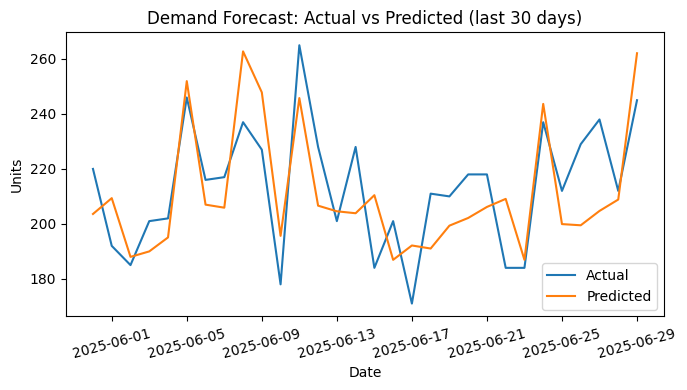

In [2]:
# Plot Actual vs Predicted
plt.figure(figsize=(7,4))
plt.plot(test["Date"], yte.values, label="Actual")
plt.plot(test["Date"], test["Pred"].values, label="Predicted")
plt.title("Demand Forecast: Actual vs Predicted (last 30 days)")
plt.xlabel("Date"); plt.ylabel("Units")
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [3]:
# What-if: With and without promo tomorrow
tomorrow = pd.DataFrame({
    "Promo":[0,1],
    "DoW":[(df["DoW"].iloc[-1]+1)%7]*2,
    "Lag1":[df["Demand"].iloc[-1]]*2
})
scen = pd.DataFrame({"Scenario":["No Promo","Promo"], "Forecast": model.predict(tomorrow).round(0)})
scen

,Scenario,Forecast
0,No Promo,195.0
1,Promo,249.0


In [17]:
[(df["DoW"].iloc[-1]+1)%7]*2

[0, 0]

**Discussion prompts**
- Is the model good enough for weekly planning?
- Which additional features would you add in a real retailer (holiday, price, weather)?


# 🔧 Addendum: Scenario Experiments for Predictive Analytics

This section adds **five self-contained scenarios** to explore model behavior and business implications.
Each scenario can be run independently and compares results to a **baseline**.

## Scenario 0 — Baseline Reference

Trains the baseline linear regression model and stores the baseline MAE for later comparison.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Baseline feature set (adapt to your existing columns)
base_features = ["Promo", "Lag1", "DoW"]  # extend if your notebook used more features
X = df[base_features]
y = df["Demand"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

mae_baseline = mean_absolute_error(y_test, y_pred_base)
print(f"Baseline MAE: {mae_baseline:.2f}")

Baseline MAE: 12.45


## Scenario 1 — Promotion Frequency ↑ (0.2 → 0.4)

Purpose: test how **more frequent promotions** (more volatility) affect forecast accuracy.

In [5]:
import numpy as np

df1 = df.copy()
rng = np.random.default_rng(42)

# Increase promotion probability to 0.4
df1["Promo"] = (rng.random(len(df1)) < 0.4).astype(int)

X = df1[base_features]
y = df1["Demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

m1 = LinearRegression().fit(X_train, y_train)
y_pred_1 = m1.predict(X_test)
mae_1 = mean_absolute_error(y_test, y_pred_1)

print(f"Scenario 1 - MAE after Promo↑ to 0.4: {mae_1:.2f}")
print(f"ΔMAE vs baseline: {mae_1 - mae_baseline:+.2f}")

Scenario 1 - MAE after Promo↑ to 0.4: 19.27
ΔMAE vs baseline: +6.82


## Scenario 2 — Remove Lag Feature (drop `Lag1`)

Purpose: test the **importance of memory** in the model.

In [6]:
features2 = ["Promo", "DoW"]
X = df[features2]
y = df["Demand"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
m2 = LinearRegression().fit(X_train, y_train)
y_pred_2 = m2.predict(X_test)
mae_2 = mean_absolute_error(y_test, y_pred_2)

print(f"Scenario 2 - MAE without Lag1: {mae_2:.2f}")
print(f"ΔMAE vs baseline: {mae_2 - mae_baseline:+.2f}")

Scenario 2 - MAE without Lag1: 13.00
ΔMAE vs baseline: +0.56


## Scenario 3 — Add Noise (±20) to `Demand`

Purpose: simulate **market randomness** and observe coefficient / error stability.

In [7]:
df3 = df.copy()
rng = np.random.default_rng(7)

df3["Demand"] = df3["Demand"] + rng.integers(-20, 21, size=len(df3))

X = df3[base_features]
y = df3["Demand"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
m3 = LinearRegression().fit(X_train, y_train)
y_pred_3 = m3.predict(X_test)
mae_3 = mean_absolute_error(y_test, y_pred_3)

print(f"Scenario 3 - MAE with ±20 noise: {mae_3:.2f}")
print(f"ΔMAE vs baseline: {mae_3 - mae_baseline:+.2f}")

Scenario 3 - MAE with ±20 noise: 15.65
ΔMAE vs baseline: +3.20


## Scenario 4 — New Feature `IsWeekend` (DoW ≥ 5)

Purpose: enrich features with **calendar signal** and test if accuracy improves.

In [8]:
df4 = df.copy()
df4["IsWeekend"] = (df4["DoW"] >= 5).astype(int)

features4 = ["Promo", "Lag1", "DoW", "IsWeekend"]
X = df4[features4]
y = df4["Demand"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
m4 = LinearRegression().fit(X_train, y_train)
y_pred_4 = m4.predict(X_test)
mae_4 = mean_absolute_error(y_test, y_pred_4)

print(f"Scenario 4 - MAE with IsWeekend: {mae_4:.2f}")
print(f"ΔMAE vs baseline: {mae_4 - mae_baseline:+.2f}")

Scenario 4 - MAE with IsWeekend: 9.84
ΔMAE vs baseline: -2.61


## Scenario 5 — What-If: Promo vs No Promo (Tomorrow)

Purpose: demonstrate **managerial what-if** using the trained baseline model.

In [9]:
# Assume tomorrow's conditions
tomorrow = pd.DataFrame({
    "Promo": [0, 1],
    "Lag1": [df["Demand"].iloc[-1]] * 2,
    "DoW":  [(df["DoW"].iloc[-1] + 1) % 7] * 2
})

pred_tomorrow = baseline_model.predict(tomorrow)
what_if = pd.DataFrame({
    "Scenario": ["No Promo", "Promo Active"],
    "Predicted_Demand": pred_tomorrow.round(2)
})
what_if, print(f"Expected uplift due to promo: {pred_tomorrow[1] - pred_tomorrow[0]:.2f}")

Expected uplift due to promo: 48.91


(       Scenario  Predicted_Demand
 0      No Promo            195.61
 1  Promo Active            244.51,
 None)

## Summary — MAE Comparison Across Scenarios

In [10]:
import pandas as pd

summary = pd.DataFrame({
    "Scenario": [
        "Baseline", "Promo↑ 0.4", "No Lag1",
        "Demand ±20 Noise", "Add IsWeekend"
    ],
    "MAE": [mae_baseline, mae_1, mae_2, mae_3, mae_4],
    "ΔMAE_vs_Baseline": [
        0,
        mae_1 - mae_baseline,
        mae_2 - mae_baseline,
        mae_3 - mae_baseline,
        mae_4 - mae_baseline
    ]
}).round(2)

summary

,Scenario,MAE,ΔMAE_vs_Baseline
0,Baseline,12.45,0.00
1,Promo↑ 0.4,19.27,6.82
2,No Lag1,13.00,0.56
3,Demand ±20 Noise,15.65,3.20
4,Add IsWeekend,9.84,-2.61


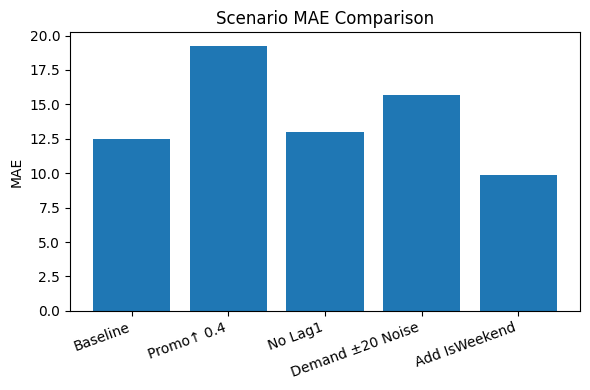

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(summary["Scenario"], summary["MAE"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("MAE")
plt.title("Scenario MAE Comparison")
plt.tight_layout()
plt.show()